In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anim

from constants import SimConstants

In [2]:
framerate = 15
writer = anim.PillowWriter(fps=framerate)

## Analysis

In [3]:
def get_time_step(i_frame: int, frame_rate: int, time_inc: float) -> int:
    """Get the time step corresponding to actual time passed of simulation.

    Example:
        50 fps -> 0.02s per frame
        0.01 time_inc -> 2 time steps per frame
        3 frames -> 6 time_steps

    Args:
        i_frame: The frame currently being rendered:
        frame_rate: Number of frames rendered per second.
        time_inc: The time passed between time steps.
    """
    return int((i_frame / frame_rate) / time_inc)

In [4]:
i_px = 0
i_py = 1
i_vx = 2
i_vy = 3
i_fx = 4
i_fy = 5
i_pr = 6
i_ps = 7

In [5]:
def read_data(name='n=500,w=10,v=7.5'):
    sconst = SimConstants.from_file(f"./data/const_{name}.json")
    data_csv = pd.read_csv(f"./data/hist_{name}.csv")
    data_arr = data_csv.to_numpy()
    data = data_arr.reshape(sconst.n_time_steps, -1, *data_arr.shape[1:])
    
    return data, sconst

In [11]:
data1, sconst1 = read_data(name='n=500,w=20,v=10')
data2, sconst2 = read_data(name='n=100,w=15,v=7.5')
data3, sconst3 = read_data(name='n=300,w=15,v=5')
data4, sconst4 = read_data(name='n=500,w=10,v=10')

# print(data.shape)

In [45]:
%matplotlib inline
nameList = ['n=100,w=15,v=7.5','n=300,w=15,v=5','n=500,w=20,v=10','n=500,w=10,v=10']

allign_coefs = []
avg_densities = []

for name in nameList:

    avg_densities1 = np.zeros(sconst1.n_time_steps)
    allign_coefs1 = np.zeros(sconst1.n_time_steps)

    data1, sconst1 = read_data(name=name)


    for t in range(sconst1.n_time_steps):
        positions = data1[t, :, i_px:i_py+1]
        velocities = data1[t, :, i_vx:i_vy+1]
        forces = data1[t, :, i_fx:i_fy+1]
        pressures = data1[t, :, i_pr]
        person_state = data1[t, :, i_ps]

        velocities[person_state > 0] = 0
        
        counts = np.zeros(sconst1.n_individuals)
        
        mean_velocity = np.linalg.norm(np.mean(velocities, axis=0))+0.000000001
        sum_velocity = np.sum(velocities/sconst1.v_max, axis=0)
        allign_coefs1[t] = np.linalg.norm(sum_velocity)
        
        for i in range(sconst1.n_individuals):
            circle_rad = 1
            circle_area = circle_rad*np.pi*np.pi
            distances = np.linalg.norm(positions[i] - positions, axis=1)
            counts[i] = np.sum(distances < circle_rad)

        avg_densities1[t] = np.mean(counts)/circle_area


    allign_coefs.append(allign_coefs1 / sconst1.n_individuals)
    avg_densities.append(avg_densities1)
    time_steps = np.arange(sconst1.n_time_steps)


        

In [46]:
def get_n_with_status_t(data, sconst, status):
    living_states = data[:, :, i_ps]
    return np.sum(living_states == status, axis=1)

nameList = ['n=100,w=15,v=7.5','n=300,w=15,v=5','n=500,w=20,v=10','n=500,w=10,v=10']
NList = [500,100,300,500]
n_deadList=[]
n_exitedList=[]
for name,N in zip(nameList,NList):
    data, sconst = read_data(name=name)

    n_deadList.append(get_n_with_status_t(data, sconst, sconst.s_dead)/N)
    n_exitedList.append(get_n_with_status_t(data, sconst, sconst.s_exited)/N)

# plt.plot(time_steps,n_dead)
# n_deadList[0]

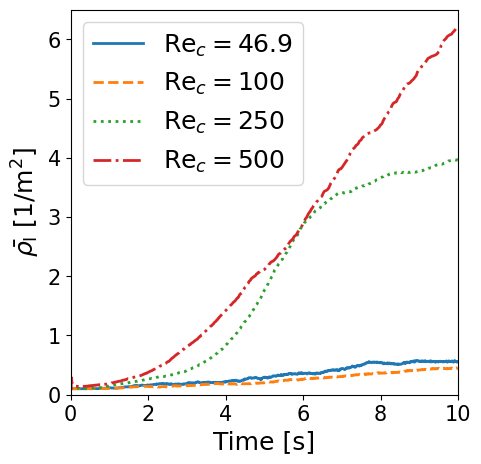

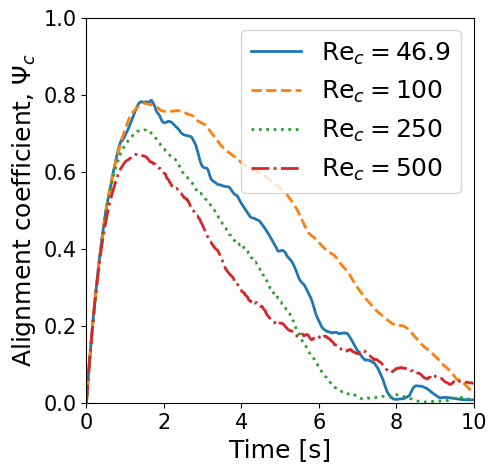

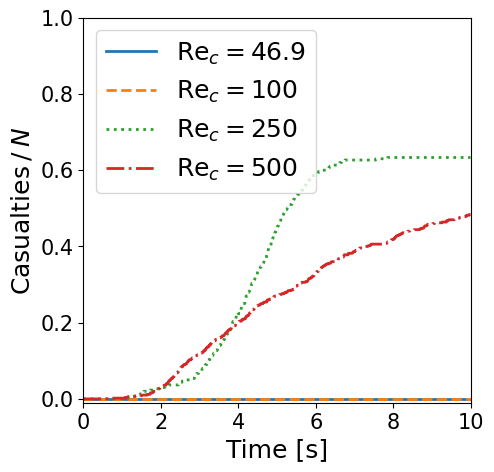

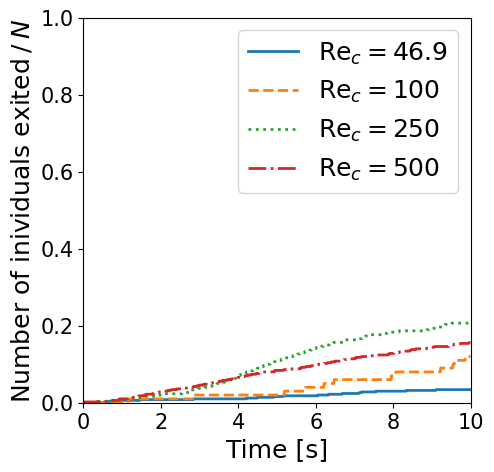

In [66]:
linestyleList=['-','--',':','-.']
legendList = [r'Re$_c=46.9$',r'Re$_c=100$',r'Re$_c=250$',r'Re$_c=500$']
fig = plt.figure(figsize=(5,5))
for i in range(4):
    plt.plot(time_steps * sconst1.time_inc, avg_densities[i],linestyle=linestyleList[i],linewidth=2, label=legendList[i])
plt.xlim(0,10)
plt.ylim(0,6.5)
plt.legend(fontsize=18)
plt.xlabel("Time [s]",fontsize=18)
plt.ylabel(r"$\bar{\rho_\mathrm{I}} \ [1/\mathrm{m}^2]$",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()


fig = plt.figure(figsize=(5,5))
for i in range(4):
    plt.plot(time_steps[:] * sconst1.time_inc, allign_coefs[i][:],linestyle=linestyleList[i],linewidth=2, label=legendList[i])
# plt.plot(time_steps[:] * sconst1.time_inc, allign_coefs2[:])
plt.legend(fontsize=18)
plt.ylim((0,1))
plt.xlim(0,10)
plt.ylabel(r"Alignment coefficient, $\Psi_c$",fontsize=18)
plt.xlabel("Time [s]",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

fig=plt.figure(figsize=(5,5))
for i in range(4):
    plt.plot(time_steps[:] * sconst1.time_inc, n_deadList[i],linestyle=linestyleList[i],linewidth=2, label=legendList[i])
plt.ylim((-0.01,1))
plt.xlim(0,10)
plt.legend(fontsize=18)
plt.xlabel("Time [s]",fontsize=18)
plt.ylabel(r"Casualties$\: / \: N$",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


fig=plt.figure(figsize=(5,5))
for i in range(4):
    plt.plot(time_steps[:] * sconst1.time_inc, n_exitedList[i],linestyle=linestyleList[i],linewidth=2, label=legendList[i])
plt.ylim((0,1))
plt.xlim(0,10)
plt.legend(fontsize=18)
plt.xlabel("Time [s]",fontsize=18)
plt.ylabel(r"Number of inividuals exited$ \: / \: N$",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [18]:
%matplotlib notebook

fig = plt.figure()
xs = []
ys = []
ax = fig.gca()
pt = ax.plot(xs, ys)[0]
ax.set_ylim((0,1))
ax.set_xlim(0, 10)
ax.set_ylabel(r"$\Psi$")
ax.set_xlabel("Time [s]")

def animate_alignment(i_frame, pt):
    i = get_time_step(i_frame, framerate, sconst.time_inc)
    
    pt.set_xdata(time_steps[:i]*sconst.time_inc)
    pt.set_ydata(allign_coefs[:i])

    return pt,

animation_alignment = anim.FuncAnimation(fig=fig, func=animate_alignment, fargs=(pt,),
                                         frames=sconst.simulation_time*framerate, blit=True,
                                         interval=int(1000/framerate))
animation_alignment.save('gifs/alignment_n=500,w=20,v=10.gif', writer=writer)

<IPython.core.display.Javascript object>

In [21]:
fig = plt.figure()
xs = []
ys = []
ax = fig.gca()
pt = ax.plot(xs, ys)[0]
ax.set_ylim((0,5))
ax.set_xlim(0, 10)
plt.ylabel(r"$\rho \ [1/m^2]$")
ax.set_xlabel("Time [s]")

def animate_density(i_frame, pt):   
    i = get_time_step(i_frame, framerate, sconst.time_inc)
    
    pt.set_xdata(time_steps[:i]*sconst.time_inc)
    pt.set_ydata(avg_densities[:i])

    return pt,

animation_density =anim.FuncAnimation(fig=fig, func=animate_density, fargs=(pt,),
                                         frames=sconst.simulation_time*framerate, blit=True,
                                         interval=int(1000/framerate))
animation_density.save('gifs/density_n=500,w=20,v=10.gif', writer=writer)

<IPython.core.display.Javascript object>

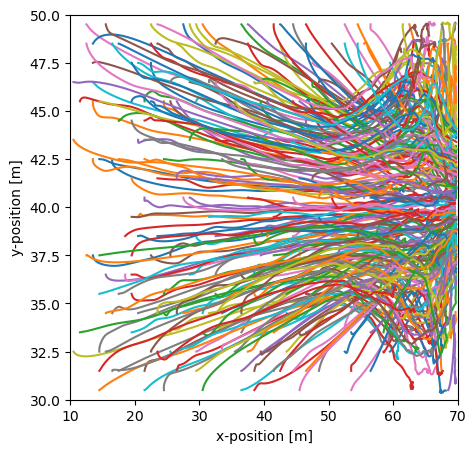

In [23]:
%matplotlib inline

fig = plt.figure(figsize=(5,5))
plt.xlim(sconst.left_inner, sconst.right_inner)
plt.ylim(sconst.bot_inner, sconst.top_inner)
particles = np.arange(300)

plt.xlabel("x-position [m]")
plt.ylabel("y-position [m]")
plt.plot(data[:, particles, 0], data[:, particles, 1]);

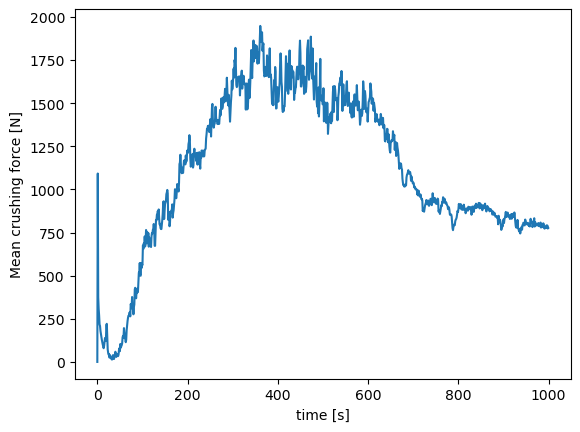

In [24]:
living_states = data[:, :, 7]
pressures = data[living_states==sconst.s_living, 6]
fig = plt.figure()
plt.xlabel("time [s]")
plt.ylabel("Mean crushing force [N]")
plt.plot(time_steps, np.mean(data[:, :, 6], axis=1));

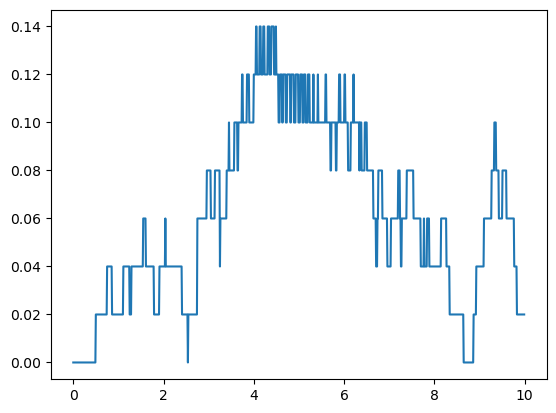

In [25]:
# Number of people leaving as a function of time
living_states = data[:, :, 7]
n_leaving = (living_states == sconst.s_exited).astype(int)
n_leaving_t = n_leaving[1:] - n_leaving[:-1]

n_frames = sconst.n_time_steps
avg_window = 50
n_leaving_t_avg = np.zeros(n_frames)
n_left = np.sum(n_leaving_t, axis=1)
for i in range(avg_window, n_frames):
    window = n_left[i-avg_window:i]
    n_leaving_t_avg[i] = np.mean(window)

plt.plot(np.arange(1000)*sconst.time_inc, n_leaving_t_avg);

/var/folders/dl/vpcfhfnd2wn62fbcrls_d41c0000gn/T/ipykernel_89929/4179801378.py:3: RuntimeWarning: divide by zero encountered in true_divide
  reynold = avg_densities * sconst.v_max * sconst.width / n_leaving_t_avg


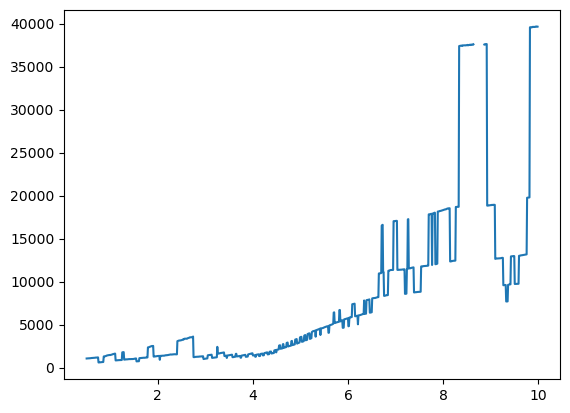

In [26]:
# Reynolds number
#reynold = np.zeros(sconst.n_time_steps)
reynold = avg_densities * sconst.v_max * sconst.width / n_leaving_t_avg
plt.plot(np.arange(sconst.n_time_steps)*sconst.time_inc, reynold)

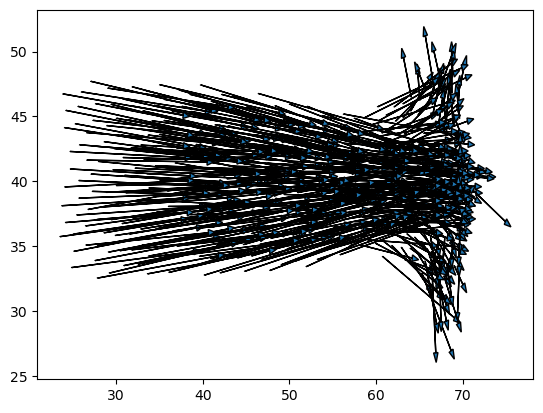

In [27]:


frame = 200

pos_info = data[frame, :, :4]
fig = plt.figure()
ax = fig.gca()
arrow_len = 1.5
for i in range(sconst.n_individuals):
    ax.arrow(pos_info[i, 0], pos_info[i, 1], arrow_len*pos_info[i, 2], arrow_len*pos_info[i, 3], head_width=0.5)
#plt.streamplot(pos_info[unique_xs, 0], pos_info[:, 1], pos_info[:, 2], pos_info[:, 3])



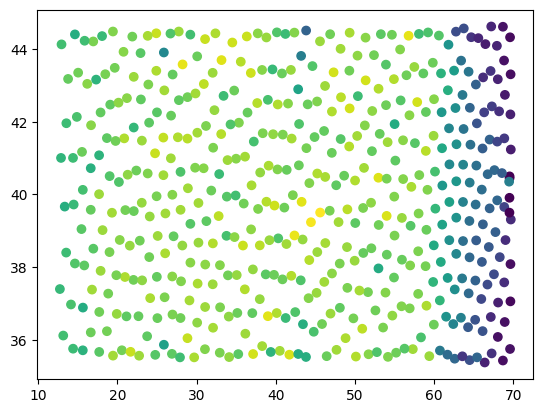

interactive(children=(IntSlider(value=100, description='frame', max=1000), Output()), _dom_classes=('widget-in…

In [16]:
from ipywidgets import interact, interactive

fig = plt.figure()
pos_info = data[100, :, :4]
im = plt.scatter(pos_info[:, 0], pos_info[:, 1], c=np.linalg.norm(pos_info[:, 2:4], axis=1))



@interact(frame=(0, 1000))
def vel_density(frame=100):
    pos_info = data[frame, :, :4]

    im = plt.scatter(pos_info[:, 0], pos_info[:, 1], c=np.linalg.norm(pos_info[:, 2:4], axis=1))
    plt.colorbar(im)



## Rework

In [29]:
def get_reynold_number(data, sconst):
    living_states_end = data[-1, :, i_ps]
    n_exited = np.sum(living_states_end == sconst.s_exited)
    avg_exited = n_exited / sconst.simulation_time
      
    density = sconst.n_individuals/(sconst.width*sconst.length)
    reynold = density * sconst.v_max * sconst.length / avg_exited
    return reynold
    


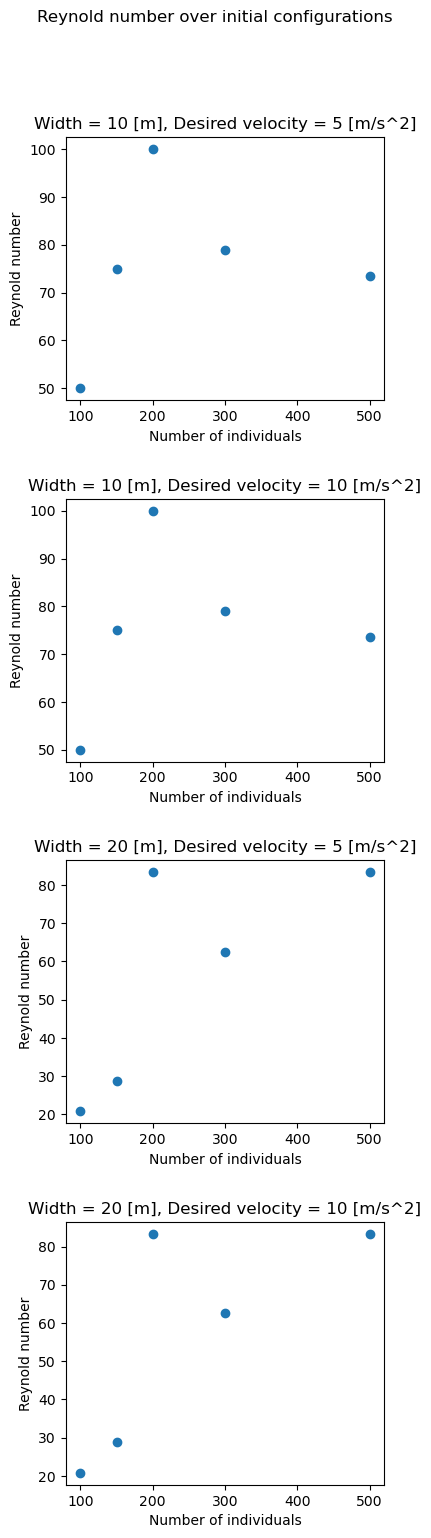

In [30]:
%matplotlib inline

wvs = [(10, 5), (10, 10), (20, 5), (20, 10)]
n_params = len(wvs)

fig, axes = plt.subplots(n_params, 1, figsize=(5,4*n_params))
fig.suptitle("Reynold number over initial configurations")
fig.tight_layout(pad=5)

for i, (w, v) in enumerate(wvs):
    ns = (100, 150, 200, 300, 500)
    reynold_nums = []

    for n in ns:
        data, sconst = read_data(name=f"n={n},w={w},v={5}")
        reynold = get_reynold_number(data, sconst)
        reynold_nums.append(reynold)

    ax = axes[i]
    ax.scatter(ns, reynold_nums)
    ax.set_title(f"Width = {w} [m], Desired velocity = {v} [m/s^2]")
    ax.set_xlabel("Number of individuals")
    ax.set_ylabel("Reynold number")


In [36]:
def get_n_dead_t(data, sconst):
    living_states = data[:, :, i_ps]
    return np.sum(living_states == sconst.s_dead, axis=1)

In [37]:
# N dead time

data_10, sconst_10 = read_data(name=f"n=500,w=10,v=7.5")
data_20, sconst_20 = read_data(name=f"n=500,w=20,v=7.5")

n_dead_10 = get_n_dead_t(data_10, sconst_10)
n_dead_20 = get_n_dead_t(data_20, sconst_20)

def animate_dead(i_frame, pt, n_dead):
    i = get_time_step(i_frame, framerate, sconst.time_inc)
    
    pt.set_xdata(time_steps[:i]*sconst.time_inc)
    pt.set_ydata(n_dead[:i])

    return pt,

<IPython.core.display.Javascript object>


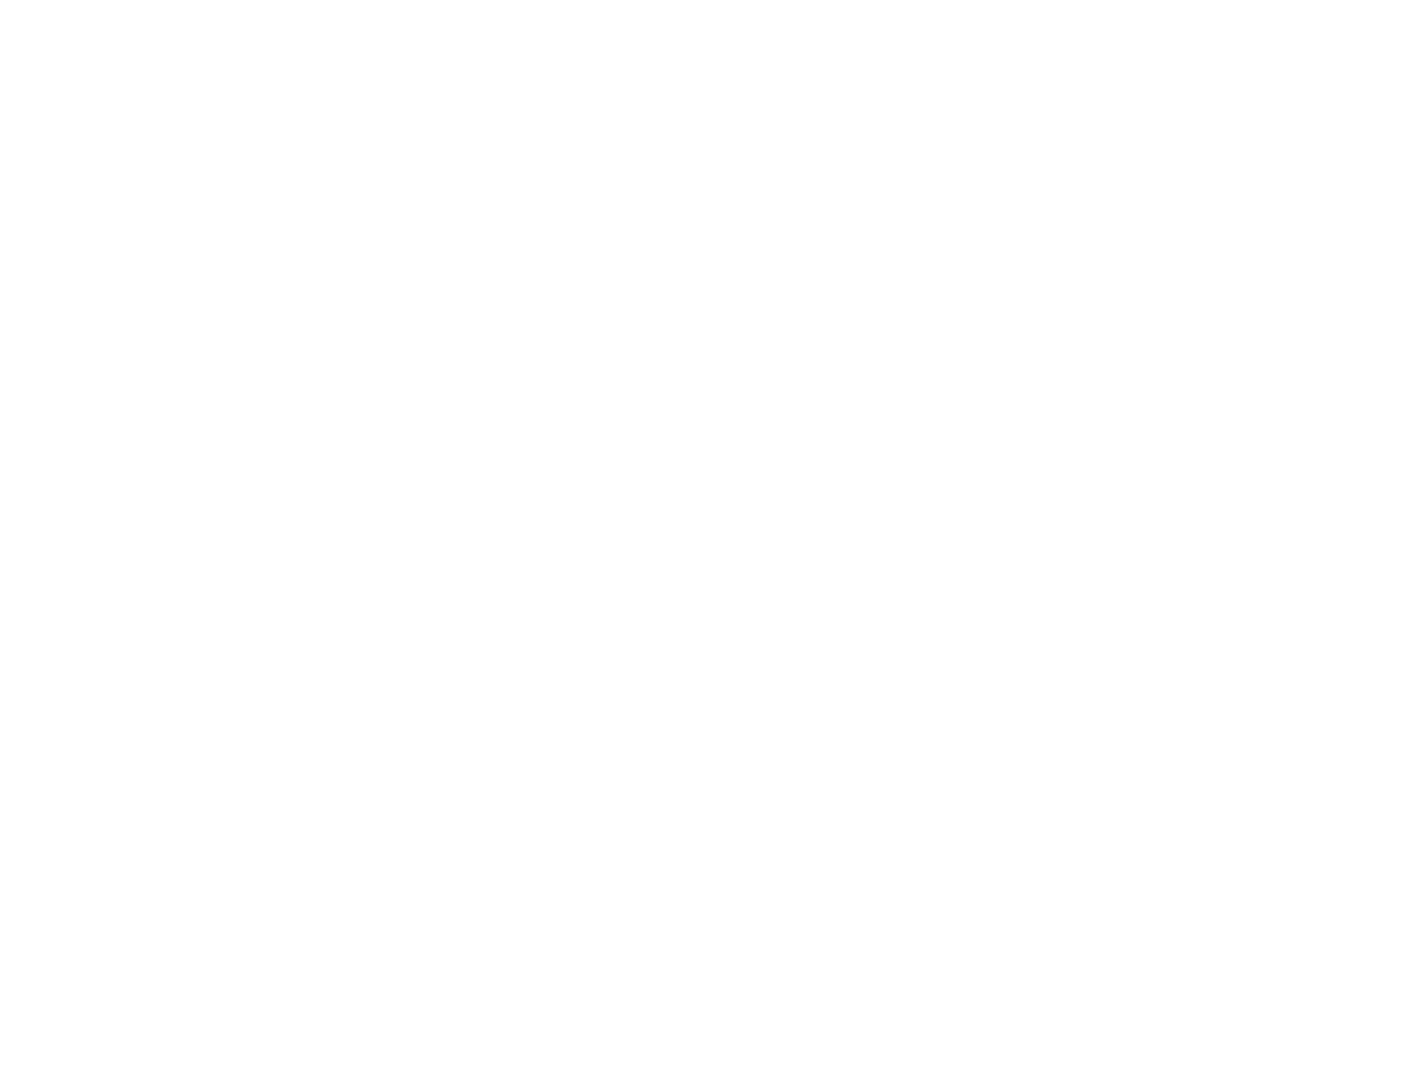

In [38]:
%matplotlib notebook

fig = plt.figure()
xs = []
ys = []
ax = fig.gca()
pt = ax.plot(xs, ys)[0]
ax.set_ylim(0, 500)
ax.set_xlim(0, 10)
ax.set_ylabel("Number of casualties")
ax.set_xlabel("Time [s]")

animation_dead_10 = anim.FuncAnimation(fig=fig, func=animate_dead, fargs=(pt, n_dead_10),
                                         frames=sconst.simulation_time*framerate, blit=True,
                                         interval=int(1000/framerate))
animation_dead_10.save('gifs/casualties_n=500,w=10,v=7.5.gif', writer=writer)

<IPython.core.display.Javascript object>


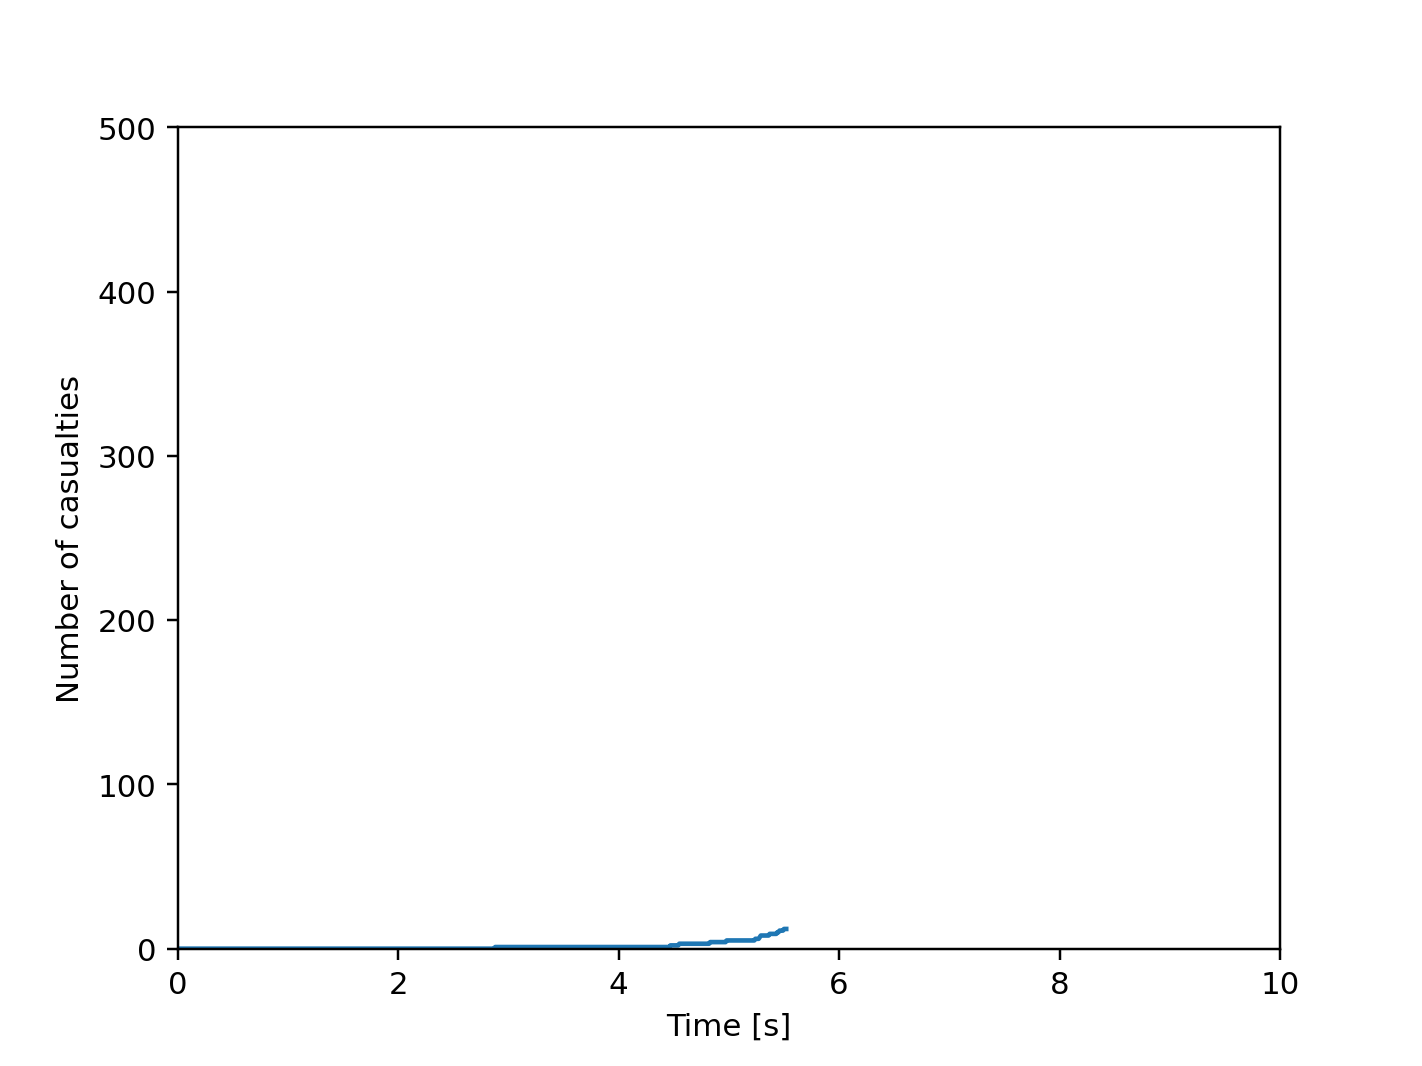

In [39]:
%matplotlib notebook

fig = plt.figure()
xs = []
ys = []
ax = fig.gca()
pt = ax.plot(xs, ys)[0]
ax.set_ylim(0, 500)
ax.set_xlim(0, 10)
ax.set_ylabel("Number of casualties")
ax.set_xlabel("Time [s]")

animation_dead_20 = anim.FuncAnimation(fig=fig, func=animate_dead, fargs=(pt, n_dead_20),
                                         frames=sconst.simulation_time*framerate, blit=True,
                                         interval=int(1000/framerate))
animation_dead_20.save('gifs/casualties_n=500,w=20,v=7.5.gif', writer=writer)